In [1]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.cluster.hierarchy as shc
from matplotlib import cm
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
font_name = "simsun"
mpl.rcParams['font.family']=font_name
mpl.rcParams['axes.unicode_minus']=False
plt.style.use('ggplot')

In [52]:
#需要改成自己的file path
data = pd.read_csv("")

In [53]:
data.shape

(1644970, 7)

In [54]:
# remove data samples without comment: evaluations without comment may not contribute to final movie score.
data = data.loc[~data["comment"].isnull()]
data = data.drop_duplicates(["uid", "name"])
data.shape

(571708, 7)

In [55]:
data.name = data.name.str.replace(' ', '')

In [56]:
def new_name(row):
    name = re.sub('\W+','', row["name"])
    date = row["date"]
    date = date.replace("-", "")
    if row["rating"] in {4, 5}:
        level = "High"
    elif row["rating"] in {1, 2}:
        level = "Low"
    else:
        level = "Medium"
    return "".join([name, level])
data["name"] = data.apply(lambda x: new_name(x), axis=1)

In [57]:
data["name"]

0                         重启之极海听雷High
1                              局中人Low
2                           隐秘的角落High
3                            三千鸦杀High
4                            霹雳侠峰High
                      ...            
1644932            情书LoveLetterMedium
1644937            超脱DetachmentMedium
1644942    大河恋ARiverRunsThroughItHigh
1644957                    心花路放Medium
1644958                     寻龙诀Medium
Name: name, Length: 571708, dtype: object

In [58]:
frequencies = data["name"].value_counts()

In [59]:
threshold = len(set(data["name"])) * 0.0005
threshold

20.177

In [60]:
frequencies[frequencies > threshold]

隐秘的角落High                                  6258
重启之极海听雷High                                5910
以家人之名High                                  4114
穿越火线High                                   3555
琉璃High                                     3103
                                           ... 
遥望南方的童年High                                  21
罪恶之家AnInspectorCallsHigh                     21
海绵宝宝历险记TheSpongeBobSquarePantsMovieHigh      21
无间道正序版High                                   21
排球少年第四季ハイキューTOTHETOPHigh                     21
Name: name, Length: 3715, dtype: int64

In [61]:
data = data.loc[data["name"].isin(frequencies[frequencies > threshold].index)]

In [62]:
data.shape

(457898, 7)

In [63]:
data_dict = data.groupby("uid").agg({"name": lambda x: ','.join(x)}).to_dict(orient="index")

In [64]:
doc_dict = dict()
for uid, value in data_dict.items():
    doc_dict[uid] = value["name"].split(",")

In [66]:
collect_history = defaultdict(set)
for uid, value_list in doc_dict.items():
    #value_list = sorted(value_list)
    if len(value_list) >= 10:
        collect_history[", ".join(value_list)].add(uid)
collect_keys = list(collect_history.keys())
vectorizer = CountVectorizer()
transformed_collect_history = vectorizer.fit_transform(collect_keys)
print(transformed_collect_history.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [68]:
sim_df = cosine_similarity(transformed_collect_history.toarray())

In [69]:
print(len(collect_keys))

17070


In [70]:
sim_df = pd.DataFrame(sim_df)
sim_df

,0,1,2,3,4,5,6,7,8,9,...,17060,17061,17062,17063,17064,17065,17066,17067,17068,17069
0,1.000000,0.000000,0.043519,0.192847,0.130558,0.029013,0.029566,0.065795,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.037689,0.036564,0.031435,0.040291,0.0,0.047673
1,0.000000,1.000000,0.000000,0.113961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.080582,0.000000,0.000000,0.000000,0.000000,0.000000,0.055728,0.000000,0.0,0.000000
2,0.043519,0.000000,1.000000,0.000000,0.083333,0.000000,0.056614,0.125988,0.000000,0.000000,...,0.087039,0.000000,0.072169,0.000000,0.000000,0.140028,0.000000,0.000000,0.0,0.091287
3,0.192847,0.113961,0.000000,1.000000,0.123091,0.041030,0.083624,0.046524,0.000000,0.000000,...,0.064282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056980,0.0,0.067420
4,0.130558,0.000000,0.083333,0.123091,1.000000,0.111111,0.113228,0.062994,0.000000,0.103695,...,0.000000,0.057735,0.072169,0.049507,0.144338,0.000000,0.000000,0.154303,0.0,0.228218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17065,0.036564,0.000000,0.140028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.060634,0.000000,0.060634,1.000000,0.050572,0.000000,0.0,0.038348
17066,0.031435,0.055728,0.000000,0.000000,0.000000,0.000000,0.000000,0.045502,0.000000,0.000000,...,0.000000,0.000000,0.104257,0.000000,0.000000,0.050572,1.000000,0.000000,0.0,0.000000
17067,0.040291,0.000000,0.000000,0.056980,0.154303,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.066815,0.000000,0.000000,1.000000,0.0,0.000000
17068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059131,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.051709,0.000000,0.000000,0.000000,0.000000,1.0,0.000000


In [71]:
sim_df.index=collect_keys
sim_df.columns =collect_keys
print(sim_df.shape)

(17070, 17070)


In [72]:
#非常慢
cluster_result = shc.linkage(sim_df.values, metric="cosine", method="average")

In [73]:
cluster_result

array([[1.38750000e+04, 1.67600000e+04, 0.00000000e+00, 2.00000000e+00],
       [8.62700000e+03, 8.65300000e+03, 0.00000000e+00, 2.00000000e+00],
       [7.10000000e+01, 1.03600000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [3.39960000e+04, 3.41350000e+04, 9.02404180e-01, 1.70670000e+04],
       [1.05830000e+04, 3.41360000e+04, 9.05064430e-01, 1.70680000e+04],
       [3.41280000e+04, 3.41370000e+04, 9.12554489e-01, 1.70700000e+04]])

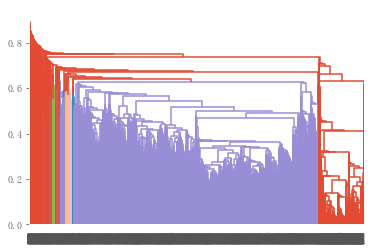

In [74]:
#非常慢
dn = shc.dendrogram(cluster_result)

In [75]:
sorted_collect_keys = [collect_keys[int(i)] for i in dn["ivl"]]

In [76]:
sorted_data_df = pd.DataFrame()
for key in sorted_collect_keys:
    for uid in collect_history[key]:
        sorted_data_df = sorted_data_df.append({"uid": uid, "history": key}, ignore_index=True)

In [77]:
prob_list = list()
num_row, num_col = sorted_data_df.shape
for idx, row in sorted_data_df.iterrows():
    prv_sim, next_sim = 0, 0
    cur_history = row["history"]
    if idx > 0:
        prv_history = sorted_data_df["history"].iloc[idx-1]
        prv_sim = sim_df[cur_history][prv_history]
    if idx < num_row-1:
        next_history = sorted_data_df["history"].iloc[idx+1]
        next_sim = sim_df[cur_history][next_history]
    prob_list.append(max(prv_sim, next_sim))     

In [78]:
sorted_data_df["prob"] = prob_list

In [124]:
machine=sorted_data_df.loc[sorted_data_df["prob"] >= 0.8]
machine=machine[["uid","history","prob"]]
machine.to_csv("data/douban_machine.csv")

In [80]:
Counter([i[0:5]for i in sorted(machine["uid"])]).most_common(20)

[('20433', 41),
 ('76635', 15),
 ('77044', 13),
 ('77037', 10),
 ('77042', 10),
 ('76784', 9),
 ('76785', 9),
 ('77045', 8),
 ('20530', 7),
 ('76672', 7),
 ('20521', 6),
 ('76649', 6),
 ('76634', 5),
 ('76654', 5),
 ('76656', 5),
 ('76830', 5),
 ('77035', 4),
 ('20040', 3),
 ('20804', 3),
 ('51904', 3)]

In [81]:
machine.shape

(2116, 3)

In [89]:
data[(data["name"].str.contains("重启之极海听雷")) & (data["rating"].isin([4,5]))].shape[0]

5910

In [92]:
machine[machine['history'].str.contains("重启之极海听雷.*High")].shape[0]

1807

In [94]:
machine[machine['history'].str.contains("重启之极海听雷.*Low")].shape[0]

43

        value
key          
高度疑似水军   1807
普通观众     4103


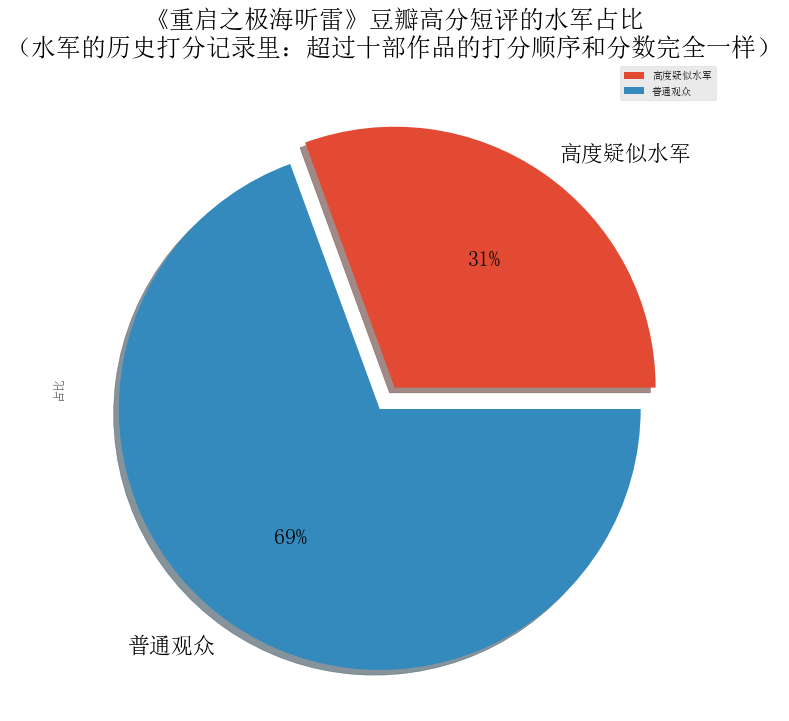

In [122]:
tmp = pd.DataFrame([["高度疑似水军", 1807], ["普通观众", 5910-1807]])
tmp.columns = ['key', 'value']
tmp = tmp.set_index('key')
print(tmp)
fig, axes = plt.subplots(figsize=(12,12))
explode = (0, 0.1)
tmp.plot.pie(fontsize=22, explode=explode, shadow=True, autopct='%1.0f%%',subplots=True, ax=axes)
axes.set_title("《重启之极海听雷》豆瓣高分短评的水军占比\n（水军的历史打分记录里：超过十部作品的打分顺序和分数完全一样）", fontsize=25)
axes.set_ylabel("占比")
plt.show()

In [106]:
data[(data["name"].str.contains("穿越火线")) & (data["rating"].isin([4,5]))].shape[0]

3555

In [107]:
machine[machine['history'].str.contains("穿越火线.*High")].shape[0]

529

        value
key          
高度疑似水军    529
普通观众     3026


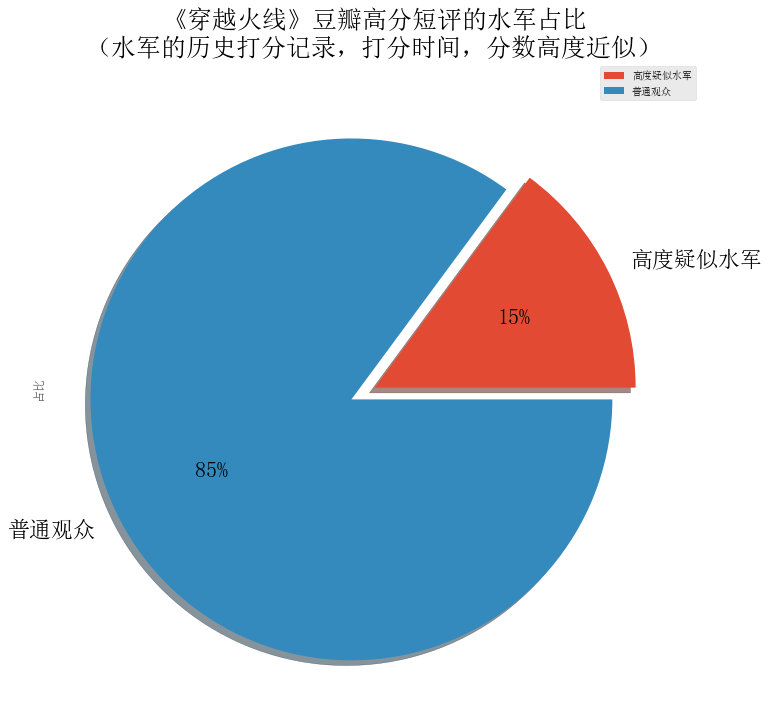

In [108]:
tmp = pd.DataFrame([["高度疑似水军", 529], ["普通观众", 3555-529]])
tmp.columns = ['key', 'value']
tmp = tmp.set_index('key')
print(tmp)
fig, axes = plt.subplots(figsize=(12,12))
explode = (0, 0.1)
tmp.plot.pie(fontsize=22, explode=explode, shadow=True, autopct='%1.0f%%',subplots=True, ax=axes)
axes.set_title("《穿越火线》豆瓣高分短评的水军占比\n（水军的历史打分记录，打分时间，分数高度近似）", fontsize=25)
axes.set_ylabel("占比")
plt.show()

In [110]:
data[(data["name"].str.contains("且听凤鸣")) & (data["rating"].isin([4,5]))].shape[0]

1006

In [111]:
machine[machine['history'].str.contains("且听凤鸣.*High")].shape[0]

341

In [116]:
data[(data["name"].str.contains("琉璃")) & (data["rating"].isin([4,5]))].shape[0]

3103

In [117]:
machine[machine['history'].str.contains("琉璃.*High")].shape[0]

69

In [118]:
data[(data["name"].str.contains("以家人之名")) & (data["rating"].isin([4,5]))].shape[0]

4114

In [119]:
machine[machine['history'].str.contains("以家人之名.*High")].shape[0]

94

In [104]:
83/4081.0

0.020338152413624112